# Когортный анализ удержания и выручки клиентов (Retention & LTV)

В этом ноутбуке выполнен когортный анализ клиентского поведения на основе реальных транзакционных данных онлайн-ритейла.

## Используемый датасет

В анализе используется датасет Online Retail II — публичный набор данных с транзакциями британской компании, занимающейся оптовой онлайн-торговлей (B2B e-commerce).

Датасет содержит информацию о покупках корпоративных клиентов за период с декабря 2009 по декабрь 2011 и включает следующие поля:
- Invoice — номер заказа,
- InvoiceDate — дата и время покупки,
- Customer ID — идентификатор клиента,
- Quantity — количество купленных товаров,
- Price — цена за единицу товара,
- Country — страна клиента.

Таким образом, данные отражают поведение B2B-клиентов с повторными покупками, крупными заказами и длинным жизненным циклом.

## Цель анализа

Цель анализа — понять, как клиенты ведут себя после первой покупки и каким образом формируется выручка бизнеса во времени.

В частности:
- как меняется удержание клиентов по месяцам жизни,
- как накапливается выручка и LTV по когортам,
- за счёт каких клиентов формируется основная часть дохода.

## Подход

Клиенты объединяются в когорты по месяцу первой покупки (CohortMonth).  
Для каждой когорты рассчитываются показатели по месяцам с момента первой покупки (CohortIndex).

В рамках анализа рассчитываются:
- Retention — доля клиентов, совершивших покупку в каждом месяце жизни,
- Накопленная выручка — суммарная выручка когорты во времени,
- LTV (Lifetime Value) — средняя накопленная выручка на одного клиента.

Дополнительно проводится анализ структуры выручки внутри когорт, чтобы объяснить различия между ними и выявить влияние отдельных крупных клиентов.

## Результат

Анализ позволяет:
- сравнить поведение разных когорт во времени,
- выявить концентрацию выручки у ограниченного числа клиентов,
- связать количественные метрики с бизнес-логикой B2B-продаж.

Результаты представлены в виде таблиц и тепловых карт (heatmap), что упрощает интерпретацию и сравнение когорт.

In [30]:
!pip install kagglehub
import kagglehub
path = kagglehub.dataset_download("mashlyn/online-retail-ii-uci")
print(path)

Using Colab cache for faster access to the 'online-retail-ii-uci' dataset.
/kaggle/input/online-retail-ii-uci


In [31]:
import os

#base_path = "/root/.cache/kagglehub/datasets/mashlyn/online-retail-ii-uci/versions/3"
base_path = "/kaggle/input/online-retail-ii-uci"
os.listdir(base_path)

['online_retail_II.csv']

In [32]:
import pandas as pd

#file_path = "/root/.cache/kagglehub/datasets/mashlyn/online-retail-ii-uci/versions/3/online_retail_II.csv"
file_path = base_path + "/online_retail_II.csv"

df = pd.read_csv(file_path)

df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [33]:
df.shape
df.columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [34]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

df["InvoiceDate"].min(), df["InvoiceDate"].max()

(Timestamp('2009-12-01 07:45:00'), Timestamp('2011-12-09 12:50:00'))

In [35]:
df = df.dropna(subset=["Customer ID"])
df["Customer ID"] = df["Customer ID"].astype(int)

df.shape

(824364, 8)

In [36]:
df = df[df["Quantity"] > 0]

df.shape

(805620, 8)

In [37]:
df["InvoiceMonth"] = df["InvoiceDate"].dt.to_period("M")

cohort = (
    df.groupby("Customer ID")["InvoiceDate"]
    .min()
    .dt.to_period("M")
)

df = df.merge(
    cohort.rename("CohortMonth"),
    on="Customer ID"
)

df["CohortIndex"] = (
    df["InvoiceMonth"] - df["CohortMonth"]
).apply(lambda x: x.n)

df[["Customer ID", "InvoiceMonth", "CohortMonth", "CohortIndex"]].head(10000)

,Customer ID,InvoiceMonth,CohortMonth,CohortIndex
0,13085,2009-12,2009-12,0
1,13085,2009-12,2009-12,0
2,13085,2009-12,2009-12,0
3,13085,2009-12,2009-12,0
4,13085,2009-12,2009-12,0
...,...,...,...,...
9995,15860,2009-12,2009-12,0
9996,15860,2009-12,2009-12,0
9997,15860,2009-12,2009-12,0
9998,15860,2009-12,2009-12,0


In [38]:
df["CohortIndex"].value_counts().sort_index().head(15)

,count
CohortIndex,
0,169882
1,40691
2,40847
3,41296
4,36552
5,34739
6,33243
7,31690
8,28714


In [40]:
df[["Customer ID", "InvoiceMonth", "CohortMonth", "CohortIndex"]].tail(20)

,Customer ID,InvoiceMonth,CohortMonth,CohortIndex
805600,13113,2011-12,2010-03,21
805601,13113,2011-12,2010-03,21
805602,13113,2011-12,2010-03,21
805603,13113,2011-12,2010-03,21
805604,12680,2011-12,2011-08,4
805605,12680,2011-12,2011-08,4
805606,12680,2011-12,2011-08,4
805607,12680,2011-12,2011-08,4
805608,12680,2011-12,2011-08,4
805609,12680,2011-12,2011-08,4


In [41]:
(
    df[df["Customer ID"] == 13085]
    [["InvoiceMonth", "CohortMonth", "CohortIndex"]]
    .drop_duplicates()
    .sort_values("InvoiceMonth")
)

,InvoiceMonth,CohortMonth,CohortIndex
0,2009-12,2009-12,0
50456,2010-01,2009-12,1
466461,2011-02,2009-12,14
583038,2011-07,2009-12,19


In [42]:
cohort_counts = (
    df
    .groupby(["CohortMonth", "CohortIndex"])["Customer ID"]
    .nunique()
    .reset_index()
)

cohort_pivot = cohort_counts.pivot(
    index="CohortMonth",
    columns="CohortIndex",
    values="Customer ID"
)

cohort_size = cohort_pivot.iloc[:, 0]

retention = cohort_pivot.divide(cohort_size, axis=0)

retention.head()

CohortIndex,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2009-12,1.0,0.352880,0.334031,0.425131,0.380105,0.359162,0.376963,0.342408,0.336126,0.362304,...,0.302618,0.262827,0.302618,0.282723,0.259686,0.255497,0.315183,0.304712,0.407330,0.196859
2010-01,1.0,0.206266,0.310705,0.305483,0.263708,0.300261,0.258486,0.229765,0.279373,0.318538,...,0.151436,0.234987,0.198433,0.185379,0.195822,0.242820,0.193211,0.245431,0.057441,NaN
2010-02,1.0,0.236702,0.223404,0.289894,0.244681,0.199468,0.191489,0.284574,0.252660,0.273936,...,0.199468,0.159574,0.162234,0.143617,0.228723,0.228723,0.162234,0.058511,NaN,NaN
2010-03,1.0,0.189616,0.230248,0.241535,0.232506,0.203160,0.246050,0.302483,0.275395,0.108352,...,0.169300,0.173815,0.155756,0.176072,0.200903,0.212190,0.079007,NaN,NaN,NaN
2010-04,1.0,0.193878,0.193878,0.163265,0.183673,0.224490,0.275510,0.261905,0.105442,0.108844,...,0.156463,0.139456,0.149660,0.180272,0.224490,0.057823,NaN,NaN,NaN,NaN


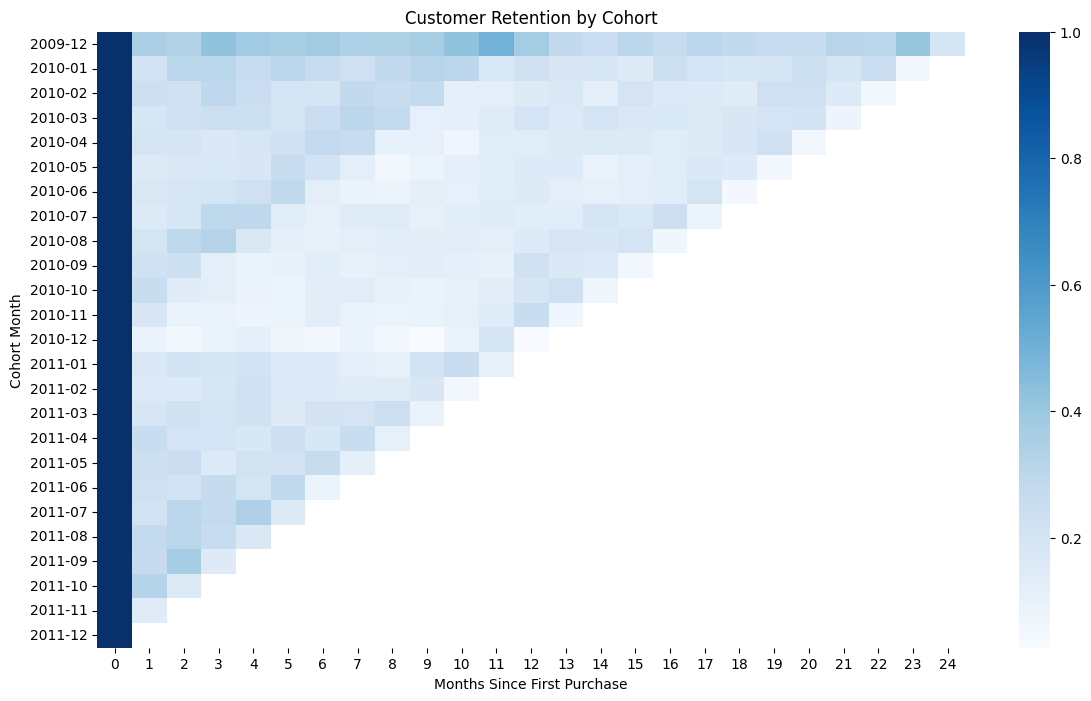

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
sns.heatmap(
    retention,
    annot=False,
    fmt=".0%",
    cmap="Blues"
)

plt.title("Customer Retention by Cohort")
plt.ylabel("Cohort Month")
plt.xlabel("Months Since First Purchase")
plt.show()

### Выводы по когортному анализу удержания

- Удержание клиентов закономерно снижается с течением времени во всех когортах.
- Более ранние когорты демонстрируют более стабильное долгосрочное удержание.
- Основной отток клиентов происходит в первые 3–4 месяца после первой покупки.
- При этом часть когорт сохраняет около 25–30% клиентов даже спустя 12 и более месяцев,
  что указывает на наличие лояльного сегмента с повторными покупками.

In [53]:
# 0) Выручка на уровне строки
df["Revenue"] = df["Quantity"] * df["Price"]

# 1) Размер когорты: сколько уникальных клиентов в каждой когорте
cohort_size = df.groupby("CohortMonth")["Customer ID"].nunique()

# 2) Матрица выручки по когортам (НЕ накопительная)
#    строки = CohortMonth, столбцы = CohortIndex, значения = сумма выручки
cohort_revenue = (
    df.groupby(["CohortMonth", "CohortIndex"])["Revenue"]
      .sum()
      .unstack(fill_value=0)
      .sort_index()
)

# 3) Накопительная выручка по времени (это уже основа LTV)
cohort_revenue_cum = cohort_revenue.cumsum(axis=1)

# 4) LTV = накопительная выручка / размер когорты (средняя выручка на клиента)
ltv = cohort_revenue_cum.divide(cohort_size, axis=0)

# 5) (опционально) ограничим горизонт, чтобы было читабельнее (например, 24 месяца)
max_months = 24
ltv_24 = ltv.loc[:, ltv.columns <= max_months]

# 6) Таблица (первые строки)
display(ltv_24.head())

CohortIndex,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2009-12,719.009592,1133.067781,1443.855354,1841.399323,2162.745731,2483.116296,2800.244631,3128.519741,3476.686066,3887.823260,...,6344.335848,6515.377001,6815.502697,7109.003881,7375.569483,7662.821336,8057.494730,8493.061473,8962.172918,9133.786761
2010-01,422.698410,524.876086,658.349350,809.076898,962.759300,1122.490762,1258.542460,1384.365749,1542.600580,1737.880266,...,2510.798047,2641.186637,2748.161702,2872.995932,2984.518752,3139.172825,3295.737943,3449.040867,3472.084888,3472.084888
2010-02,453.284266,542.026766,688.000968,830.011394,947.097936,1052.891766,1159.708761,1296.261503,1437.320811,1583.427779,...,2054.247699,2134.185412,2223.037061,2290.924428,2411.952460,2534.416662,2637.337327,2666.985120,2666.985120,2666.985120
2010-03,531.528354,644.412530,761.724652,907.979257,1021.869009,1148.426842,1296.546865,1480.810905,1654.231244,1733.790567,...,2229.950183,2326.686616,2439.631086,2546.787384,2676.599867,2817.968806,2857.039325,2857.039325,2857.039325,2857.039325
2010-04,425.512690,490.262180,560.718779,663.160446,739.044663,843.964969,963.833677,1075.313269,1127.480616,1187.677622,...,1551.533711,1612.330956,1678.397827,1787.829561,1890.139765,1906.952588,1906.952588,1906.952588,1906.952588,1906.952588


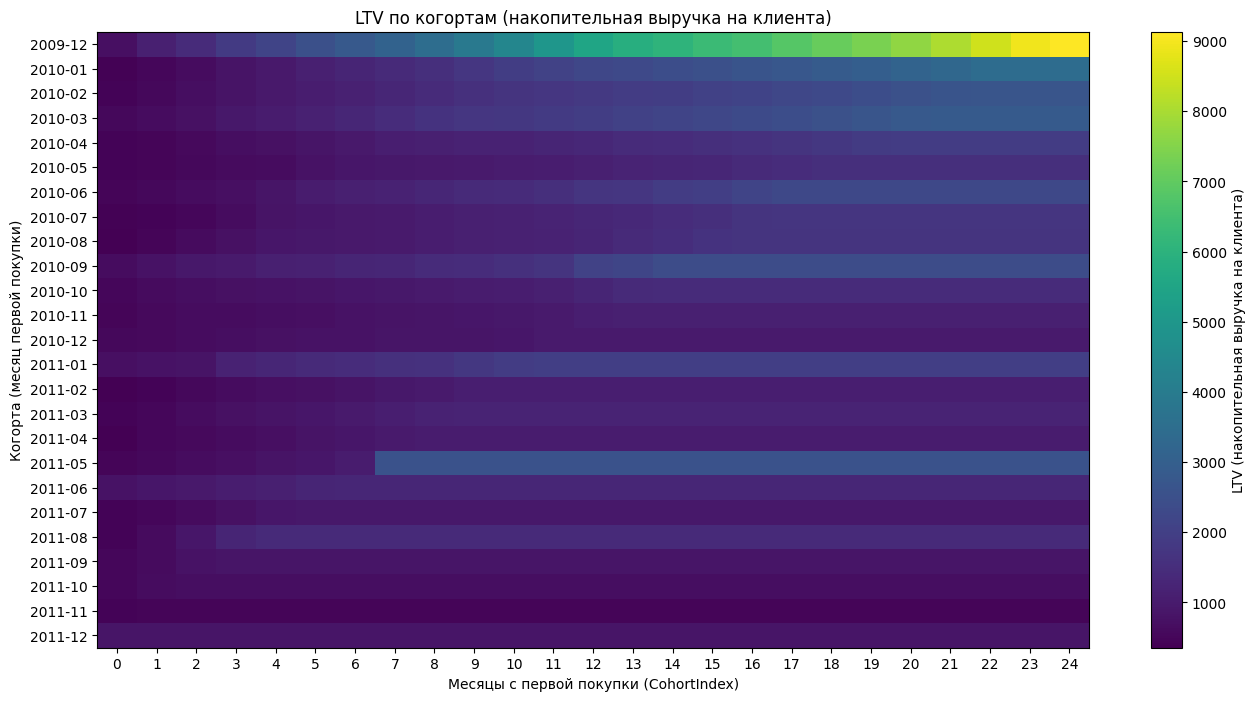

In [55]:
# 7) Heatmap LTV
import numpy as np

plt.figure(figsize=(16, 8))
plt.imshow(ltv_24, aspect="auto")
plt.colorbar(label="LTV (накопительная выручка на клиента)")
plt.title("LTV по когортам (накопительная выручка на клиента)")
plt.xlabel("Месяцы с первой покупки (CohortIndex)")
plt.ylabel("Когорта (месяц первой покупки)")

plt.yticks(
    ticks=np.arange(len(ltv_24.index)),
    labels=[str(x) for x in ltv_24.index]
)
plt.xticks(
    ticks=np.arange(len(ltv_24.columns)),
    labels=[str(x) for x in ltv_24.columns]
)

plt.show()

Выводы по когортному анализу LTV (накопительная выручка на клиента)

- Первая когорта (декабрь 2009) демонстрирует существенно более высокий LTV по сравнению с последующими когортами. Это указывает на наличие в ранний период клиентов с высокой частотой и объёмом повторных покупок.

- Для всех когорт характерна накопительная природа LTV: выручка продолжает расти на протяжении всего наблюдаемого горизонта, что соответствует B2B-модели с регулярными закупками.

- Значительная часть LTV формируется в первые 6-9 месяцев после первой покупки, однако дальнейшие повторные заказы вносят существенный вклад в итоговую выручку, особенно для ранних когорт.

- Более поздние когорты демонстрируют схожую динамику роста LTV, но с меньшим масштабом, что может быть связано с различиями в составе клиентов и среднем чеке.

- Наблюдаемые различия между когортами указывают на наличие сегмента "якорных" клиентов, обеспечивающих непропорционально высокую долгосрочную выручку.

- В целом, когортный анализ LTV подтверждает, что бизнес опирается на повторные B2B-покупки, а ранние клиенты играют ключевую роль в формировании долгосрочной выручки.

Далее проверяем гипотезу: действительно ли первая когорта это несколько якорных клиентов. Цель: доказать что высокая LTV первой когорты обусловлена небольшим числом клиентов с аномально высокой выручкой и частотой покупок.

In [56]:
cohort_size.sort_index().head(10)

,Customer ID
CohortMonth,
2009-12,955
2010-01,383
2010-02,376
2010-03,443
2010-04,294
2010-05,254
2010-06,270
2010-07,186
2010-08,162


In [57]:
cohort_revenue.sum(axis=1).sort_index().head(10)

,0
CohortMonth,
2009-12,8722766.357
2010-01,1329808.512
2010-02,1002786.405
2010-03,1265668.421
2010-04,560644.061
2010-05,392333.780
2010-06,609807.790
2010-07,317293.910
2010-08,270800.420


In [59]:
first_cohort_month = cohort_size.index.min()

first_cohort_customers = (
    df[df["CohortMonth"] == first_cohort_month]
    .groupby("Customer ID")
    .agg(
        total_revenue=("Revenue", "sum"),
        orders=("Invoice", "nunique"),
        total_items=("Quantity", "sum")
    )
    .sort_values("total_revenue", ascending=False)
)

first_cohort_customers.head(10)

,total_revenue,orders,total_items
Customer ID,,,
18102,608821.65,145,188340
14646,528602.52,152,367833
14156,313946.37,156,165992
14911,295972.63,398,150237
13694,196482.81,143,189205
17511,175603.55,60,119656
16684,147142.77,55,104810
15061,137818.52,127,80711
16029,122209.14,107,56486


In [60]:
first_cohort_customers["revenue_share"] = (
    first_cohort_customers["total_revenue"]
    / first_cohort_customers["total_revenue"].sum()
)

first_cohort_customers.head(10)[
    ["total_revenue", "orders", "revenue_share"]
]

,total_revenue,orders,revenue_share
Customer ID,,,
18102,608821.65,145,0.069797
14646,528602.52,152,0.060600
14156,313946.37,156,0.035992
14911,295972.63,398,0.033931
13694,196482.81,143,0.022525
17511,175603.55,60,0.020132
16684,147142.77,55,0.016869
15061,137818.52,127,0.015800
16029,122209.14,107,0.014010


In [61]:
later_cohort = cohort_size.index[5]

(
    df[df["CohortMonth"] == later_cohort]
    .groupby("Customer ID")
    .agg(total_revenue=("Revenue", "sum"))
    .sort_values("total_revenue", ascending=False)
    .head(10)
)

,total_revenue
Customer ID,
12409,23419.29
14936,12410.81
13102,11696.92
18052,10877.18
13324,10513.47
15034,8313.40
16145,6805.44
12656,6407.83
16458,5715.34


Итоги анализа LTV по когортам

- Первая когорта (декабрь 2009)
демонстрирует существенно более высокий LTV по сравнению с последующими когортами, что объясняется наличием значительного числа крупных B2B-клиентов с регулярными оптовыми закупками.

- Высокий LTV первой когорты не является статистическим артефактом: когорта является одной из крупнейших по размеру и генерирует непропорционально высокую выручку.

- Анализ распределения выручки внутри когорты показывает выраженную концентрацию: около 1% клиентов формируют более 30% общей выручки.

- Для всех когорт характерна накопительная динамика LTV, при которой существенная часть выручки формируется в первые 6-9 месяцев, однако для крупных клиентов значимый вклад в LTV продолжается и в более поздние периоды.

- Полученные результаты указывают на B2B-модель бизнеса с высокой зависимостью от якорных клиентов и повторных закупок.